# Project Goal
We are given a file with Twitter comments. Those comments are marked as positive/negative. We need to build a NLP model that will be able to predict the "toxicity" of comments with a minimum of 0.75 F1 Score.

# Project Plan
1. Project Goal
2. Project Plan
3. Libraries / Data Load
4. Exploratory Analysis
5. Data Preprocessing 
6. Base Model
7. Other Models
8. Results

# Libraries / Data Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os

from langdetect import detect
from collections import Counter

import nltk
nltk.download('words')
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier

[nltk_data] Downloading package words to /Users/vlad/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vlad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/vlad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
local_path = './datasets/toxic_comments.csv'
web_path = '/datasets/toxic_comments.csv'

if os.path.exists(local_path):
  df = pd.read_csv(local_path, index_col=0)
elif os.path.exists(web_path):
  df = pd.read_csv(web_path, index_col=0)

In [3]:
df.sample(5)

,text,toxic
22323,"No big deal, just thought you would want to know.",0
67537,"Oh no, you're not an annoyance. I was just pla...",0
17230,Irish slaves? omg! Where do you get this stuff...,0
23501,"""\n\nTop 40\nHere's the list of the people who...",0
12348,"""\n\nArticle rating\n\nI am rating this articl...",0


# Exploratory Analysis

- Good Link
- Exploritory Data Analysis for NLP
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<Axes: >

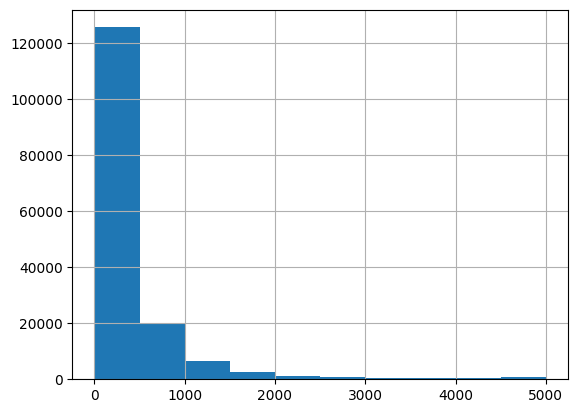

In [5]:
df.text.str.len().hist()

Most Text contain less than 200 characters

<Axes: >

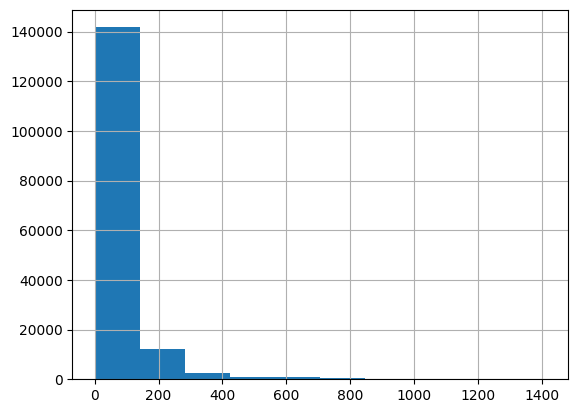

In [6]:
df.text.str.split().map(lambda x: len(x)).hist()

A lot of texts contain less than 400 words

<Axes: >

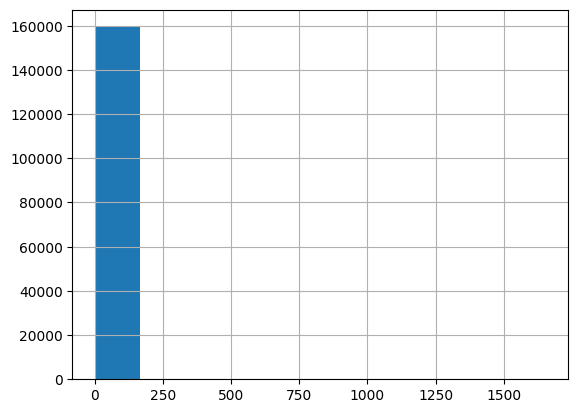

In [7]:
df.text.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

По этому графику видно что длина слов иммеет выбросы в данных.

In [8]:
def safe_detect(text):
    try:
        return detect(text)
    except:
        return '--'

languages = df.text.sample(1000).apply(lambda x: safe_detect(x))
unique_languages = languages.unique()

print("Languages found in dataframe:")
print(unique_languages)

Languages found in dataframe:
['en' 'et' 'nl' 'tr' '--' 'ca' 'fr' 'de' 'cy' 'id' 'it' 'af' 'so']


A lot of different languages

<Axes: >

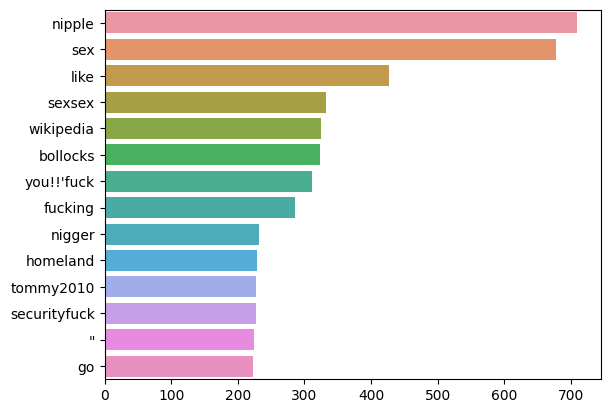

In [9]:
stop = set(nltk.corpus.stopwords.words('english'))

counter_toxic = Counter(
    np.concatenate(
        df[df.toxic == 1].text\
            .sample(1000).str.lower()\
                .str.split().values))
most = counter_toxic.most_common()

x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)

# Data Preprocessing

- Useful Post https://www.datacamp.com/tutorial/stemming-lemmatization-python

- Simple language preprocessing.
  - Remove all characters.
  - Tokenize the text.
  - Lemmatize the text.
  - Build bag of words.

In [10]:
pattern = r'[^a-zA-Z\s]|\d+'
df['text'] = df['text'].str.lower().str.replace(pattern, '', regex=True).str.split()

In [11]:
df.text.head()

0    [explanation, why, the, edits, made, under, my...
1    [daww, he, matches, this, background, colour, ...
2    [hey, man, im, really, not, trying, to, edit, ...
3    [more, i, cant, make, any, real, suggestions, ...
4    [you, sir, are, my, hero, any, chance, you, re...
Name: text, dtype: object

In [12]:
words_set = set(nltk.corpus.words.words())

In [13]:
stop = set(nltk.corpus.stopwords.words('english'))

In [14]:
step = df.text

In [15]:
def drop_stop_words(l):
    out = []
    for w in l:
        if w not in stop:
            out.append(w)
            # if w in words_set:
                # out.append(w)
    return out
step = step.apply(lambda x: drop_stop_words(x))

In [16]:
df.text = step

In [17]:
wnl = WordNetLemmatizer()

def lem_list(l):
    out = []
    for w in l:
        out.append(wnl.lemmatize(w))
    return out

step = df.text.apply(lambda l: lem_list(l))

In [18]:
step.head()

0    [explanation, edits, made, username, hardcore,...
1    [daww, match, background, colour, im, seemingl...
2    [hey, man, im, really, trying, edit, war, guy,...
3    [cant, make, real, suggestion, improvement, wo...
4           [sir, hero, chance, remember, page, thats]
Name: text, dtype: object

In [19]:
df.text = step.apply(lambda l: " ".join(l))

In [20]:
train, test = train_test_split(df, test_size=0.4, random_state=0)

In [21]:
valid, test = train_test_split(test, test_size=0.5, random_state=0)

In [22]:
count_vect = CountVectorizer(ngram_range=(1, 2))
count_vect.fit(train.text)

CountVectorizer(ngram_range=(1, 2))

In [23]:
count_tf_idf = TfidfVectorizer()
count_tf_idf.fit(train.text)

TfidfVectorizer()

теперь векторизируем все датасеты

In [24]:
X_train = hstack((count_vect.transform(train.text), count_tf_idf.transform(train.text)))

In [25]:
X_valid = hstack((count_vect.transform(valid.text), count_tf_idf.transform(valid.text)))

In [26]:
X_test = hstack((count_vect.transform(test.text), count_tf_idf.transform(test.text)))

# Base Model

In [27]:
lr_model = LogisticRegression(max_iter=1000)

In [28]:
lr_model.fit(X_train, train.toxic)

LogisticRegression(max_iter=1000)

In [29]:
z_valid = lr_model.predict(X_valid)

In [30]:
f1_score(valid.toxic, z_valid)

0.7648290300069783

# Other Models

In [31]:
gbc_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

In [32]:
gbc_model.fit(X_train, train.toxic)

GradientBoostingClassifier()

In [33]:
z_valid = gbc_model.predict(X_valid)

In [34]:
f1_score(valid.toxic, z_valid)

0.6038131154410223

# Results

In [35]:
z_test = lr_model.predict(X_test)

In [36]:
f1_score(test.toxic, z_test)

0.7631034482758621

We achieved the required f1 metric. A lot of features were produces in the process, unfortunately because a lot of toxic words are misspelled we couldn't filter the words by the dictionary, which resulted in a lot of features produced.